<a href="https://colab.research.google.com/github/GeoffHuang/Lo-Fo/blob/BACKUP-MASTER/Project%20Doodle%20%5BCNN%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROJECT DOODLE

Geoff Huang (ghuang6)  
Cesar Martin (cmarti21)

In [0]:
%matplotlib inline

In [0]:
!pip install --upgrade google-cloud-storage

Requirement already up-to-date: google-cloud-storage in /usr/local/lib/python3.6/dist-packages (1.14.0)


In [0]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'true'
core:
  disable_usage_reporting: 'True'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  Y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&prompt=select_account&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import os
import json
import seaborn as sns
import time

In [0]:
from google.cloud import storage
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Importing the Data

In [0]:
from google.cloud import storage

storage_client = storage.Client.from_service_account_json('/content/gdrive/My Drive/Colab Notebooks/quickdraw144-74a18f33ae20.json')
bucket = storage_client.get_bucket('quickdraw_dataset')

In [0]:
# We will be using the bitmap representation of the data by feeding it directly into our CNN
# We will be using the simplified dataset for some data preprocessing tasks.  
# Read our progress report for more details.

# note: for the purpose of experimenting, we are only using 10/345 of the categories
# for our final model, we will be training on a lot more than that (see below)

max_categories = 345
num_categories = 10
x = (max_categories+1)//num_categories +1

bmp_data_all = list(bucket.list_blobs(prefix='full/numpy_bitmap'))
bmp_data = bmp_data_all[::x]

simp_data_all = list(bucket.list_blobs(prefix='full/simplified'))
simp_data = simp_data_all[::x]

### Downloading the Data

In [0]:
# download certain categories of the dataset
# reshape all the bmps from 1x784 to 28x28
# store these bitmaps into x, and their category label integer into y

# note: we are also removing not recognized drawings
# note: we are also limiting the number of drawings per category

max_drawings_per_category = 10000

x = list()
y = list()

for i, category in enumerate(bmp_data):
  file_name = os.path.basename(category.name).replace(' ', '_')
  print("{0}. downloading {1}...".format(i+1, file_name))
  category.download_to_filename(file_name)
  
  temp_df = simp_data[i].download_as_string().decode('utf-8')
  temp_df = pd.read_json(temp_df, lines=True)
  temp_list = np.load(file_name)
  
  for j, drawing in enumerate(temp_list):
    if temp_df['recognized'].iloc[j] == True:
      x.append(drawing.reshape(28,28))
      y.append(i)
    if len(y) >= (i+1)*max_drawings_per_category:
      break

1. downloading The_Eiffel_Tower.npy...
2. downloading birthday_cake.npy...
3. downloading cello.npy...
4. downloading elbow.npy...
5. downloading hand.npy...
6. downloading lightning.npy...
7. downloading palm_tree.npy...
8. downloading rhinoceros.npy...
9. downloading spoon.npy...
10. downloading toilet.npy...


### Visualizing the Data

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


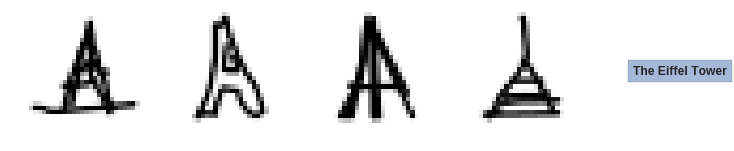

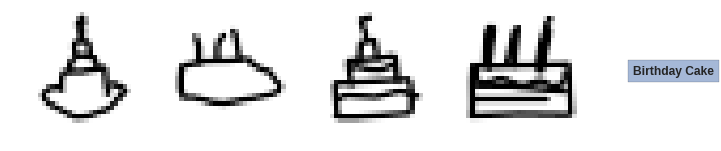

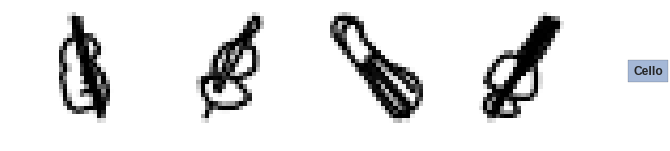

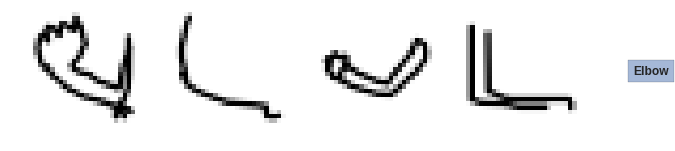

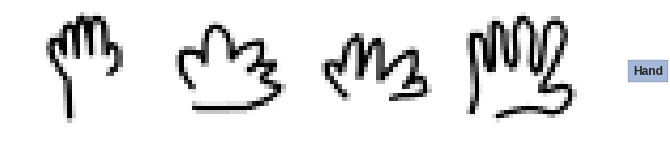

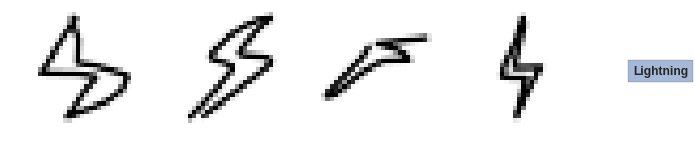

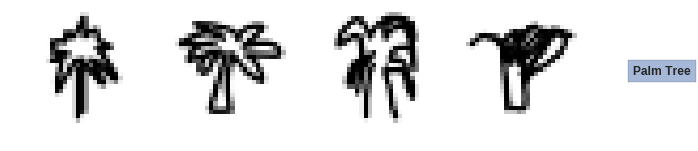

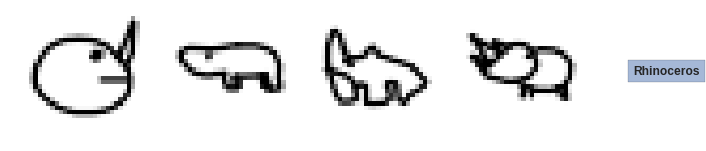

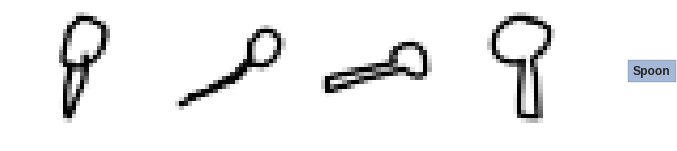

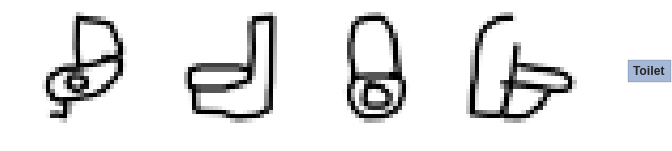

In [0]:
import matplotlib.pyplot as plt

display_num = 4  # pics per category to display
fig_length = 10  # the entire figure has size fig_side x fig_side
subplot_length = 4  # the size of each subplot in the figure has size subplot_length x subplot_length

for i, category in enumerate(bmp_data):
  fig = plt.figure(figsize=(fig_length, fig_length))
  for j in range(display_num):
    fig.add_subplot(subplot_length, subplot_length, j+1)
    plt.imshow(x[i*max_drawings_per_category+j])
    plt.axis('Off') # Don't show gridlines

  category_name = os.path.basename(category.name).title()
  category_name = os.path.splitext(category_name)[0]
  ax = fig.add_subplot(subplot_length, subplot_length, j+1)
  ax.text(40, 15, category_name, fontsize='large', fontweight='bold',
        bbox={'alpha': .5, 'pad': 5})
  
  plt.show()

###Splitting the Data

In [0]:
# split the data into training/test sets
# 80% training 20% test

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

###Creating the CNN

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras import Model

batch_size = 128
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)

In [0]:
# The CNN (MNIST)
# We'll call this "Attempt 1"

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Model summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)      

###Training the CNN

In [0]:
history1 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 80000 samples, validate on 20000 samples
Epoch 1/12
80000/80000 [==============================] - 13s 168us/step - loss: 0.4711 - acc: 0.8527 - val_loss: 0.2078 - val_acc: 0.9374
Epoch 2/12
80000/80000 [==============================] - 11s 143us/step - loss: 0.2498 - acc: 0.9234 - val_loss: 0.1674 - val_acc: 0.9494
Epoch 3/12
80000/80000 [==============================] - 12s 144us/step - loss: 0.2084 - acc: 0.9362 - val_loss: 0.1528 - val_acc: 0.9526
Epoch 4/12
80000/80000 [==============================] - 11s 143us/step - loss: 0.1802 - acc: 0.9455 - val_loss: 0.1432 - val_acc: 0.9566
Epoch 5/12
80000/80000 [==============================] - 11s 143us/step - loss: 0.1617 - acc: 0.9506 - val_loss: 0.1405 - val_acc: 0.9581
Epoch 6/12
80000/80000 [==============================] - 12s 144us/step - loss: 0.1470 - acc: 0.9545 - val_loss: 0.1273 - val_acc: 0.9620
Epoch 7/12
80000/80000 [==============================] - 11s 143us/

###Visualizing Accuracy and Loss

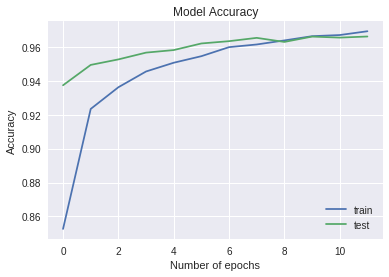

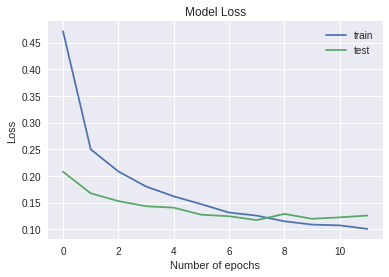

In [0]:
# The history of our accuracy during training.
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# The history of our cross-entropy loss during training.
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Modifying the CNN

In [0]:
# function that resets all the changes we've made to the data so we can test a different model

def reset():
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)
  
  x_train = np.array(x_train)
  x_test = np.array(x_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  if K.image_data_format() == 'channels_first':
      x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
      x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
      x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255

  y_train = keras.utils.to_categorical(y_train, num_categories)
  y_test = keras.utils.to_categorical(y_test, num_categories)
  
  return

In [0]:
# Attempt 2: Attempt 1, but increasing number of filters in 1st convolution layer (32 -> 64)

reset()
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history2 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 80000 samples, validate on 20000 samples
Epoch 1/12
80000/80000 [==============================] - 14s 180us/step - loss: 0.4792 - acc: 0.8496 - val_loss: 0.1989 - val_acc: 0.9384
Epoch 2/12
80000/80000 [==============================] - 14s 173us/step - loss: 0.2505 - acc: 0.9230 - val_loss: 0.1626 - val_acc: 0.9508
Epoch 3/12
80000/80000 [==============================] - 14s 173us/step - loss: 0.2050 - acc: 0.9384 - val_loss: 0.1451 - val_acc: 0.9568
Epoch 4/12
80000/80000 [==============================] - 14s 173us/step - loss: 0.1757 - acc: 0.9463 - val_loss: 0.1385 - val_acc: 0.9585
Epoch 5/12
80000/80000 [==============================] - 14s 173us/step - loss: 0.1581 - acc: 0.9514 - val_loss: 0.1305 - val_acc: 0.9603
Epoch 6/12
80000/80000 [==============================] - 14s 173us/step - loss: 0.1410 - acc: 0.9575 - val_loss: 0.1328 - val_acc: 0.9616
Epoch 7/12
80000/80000 [==============================] - 14s 173us/step - loss: 0.1293 - acc: 0.9614 - val_loss: 0.

In [0]:
# Attempt 3: Attempt 2, but adding a 3rd convolution layer with 64 3x3 filters
# Note: max pooling layer still occurs after all convolution layers

reset()
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history3 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 80000 samples, validate on 20000 samples
Epoch 1/12
80000/80000 [==============================] - 20s 249us/step - loss: 0.4988 - acc: 0.8423 - val_loss: 0.2094 - val_acc: 0.9364
Epoch 2/12
80000/80000 [==============================] - 19s 241us/step - loss: 0.2486 - acc: 0.9246 - val_loss: 0.1581 - val_acc: 0.9523
Epoch 3/12
80000/80000 [==============================] - 19s 240us/step - loss: 0.1950 - acc: 0.9415 - val_loss: 0.1361 - val_acc: 0.9595
Epoch 4/12
80000/80000 [==============================] - 19s 241us/step - loss: 0.1631 - acc: 0.9506 - val_loss: 0.1229 - val_acc: 0.9627
Epoch 5/12
80000/80000 [==============================] - 19s 240us/step - loss: 0.1432 - acc: 0.9566 - val_loss: 0.1173 - val_acc: 0.9661
Epoch 6/12
80000/80000 [==============================] - 19s 240us/step - loss: 0.1259 - acc: 0.9615 - val_loss: 0.1109 - val_acc: 0.9677
Epoch 7/12
80000/80000 [==============================] - 19s 240us/step - loss: 0.1140 - acc: 0.9650 - val_loss: 0.

In [0]:
# Attempt 4: Attempt 3, but adding 2x2 max pooling after 1st and 3rd convolution layers
# Note: this was mostly done in an attempt to lower runtime, while seeing if / how much
# accuracy is affected

reset()
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history4 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 80000 samples, validate on 20000 samples
Epoch 1/12
80000/80000 [==============================] - 10s 128us/step - loss: 0.8867 - acc: 0.7031 - val_loss: 0.3306 - val_acc: 0.8966
Epoch 2/12
80000/80000 [==============================] - 9s 119us/step - loss: 0.4114 - acc: 0.8751 - val_loss: 0.2831 - val_acc: 0.9133
Epoch 3/12
80000/80000 [==============================] - 9s 118us/step - loss: 0.3252 - acc: 0.9029 - val_loss: 0.2216 - val_acc: 0.9315
Epoch 4/12
80000/80000 [==============================] - 9s 118us/step - loss: 0.2798 - acc: 0.9167 - val_loss: 0.2165 - val_acc: 0.9339
Epoch 5/12
80000/80000 [==============================] - 9s 118us/step - loss: 0.2522 - acc: 0.9257 - val_loss: 0.2061 - val_acc: 0.9363
Epoch 6/12
80000/80000 [==============================] - 9s 118us/step - loss: 0.2315 - acc: 0.9322 - val_loss: 0.1824 - val_acc: 0.9439
Epoch 7/12
80000/80000 [==============================] - 9s 117us/step - loss: 0.2113 - acc: 0.9374 - val_loss: 0.1758 -

In [0]:
# Attempt 5: Attempt 3, but adding 2x2 max pooling after 3rd convolution layer only (not 1st)

reset()
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history5 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 80000 samples, validate on 20000 samples
Epoch 1/12
80000/80000 [==============================] - 15s 187us/step - loss: 0.5288 - acc: 0.8314 - val_loss: 0.1860 - val_acc: 0.9425
Epoch 2/12
80000/80000 [==============================] - 14s 178us/step - loss: 0.2416 - acc: 0.9259 - val_loss: 0.1369 - val_acc: 0.9577
Epoch 3/12
80000/80000 [==============================] - 14s 178us/step - loss: 0.1890 - acc: 0.9428 - val_loss: 0.1194 - val_acc: 0.9637
Epoch 4/12
80000/80000 [==============================] - 14s 178us/step - loss: 0.1613 - acc: 0.9519 - val_loss: 0.1163 - val_acc: 0.9636
Epoch 5/12
80000/80000 [==============================] - 14s 178us/step - loss: 0.1434 - acc: 0.9570 - val_loss: 0.1042 - val_acc: 0.9682
Epoch 6/12
80000/80000 [==============================] - 14s 179us/step - loss: 0.1314 - acc: 0.9605 - val_loss: 0.1073 - val_acc: 0.9677
Epoch 7/12
80000/80000 [==============================] - 14s 178us/step - loss: 0.1207 - acc: 0.9638 - val_loss: 0.

In [0]:
# Attempt 6: Attempt 5, but adding 0.25 dropout after second convolution layer

reset()
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history6 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 80000 samples, validate on 20000 samples
Epoch 1/12
80000/80000 [==============================] - 17s 211us/step - loss: 0.5532 - acc: 0.8240 - val_loss: 0.1923 - val_acc: 0.9413
Epoch 2/12
80000/80000 [==============================] - 16s 201us/step - loss: 0.2581 - acc: 0.9218 - val_loss: 0.1523 - val_acc: 0.9535
Epoch 3/12
80000/80000 [==============================] - 16s 200us/step - loss: 0.2067 - acc: 0.9382 - val_loss: 0.1211 - val_acc: 0.9637
Epoch 4/12
80000/80000 [==============================] - 16s 201us/step - loss: 0.1769 - acc: 0.9471 - val_loss: 0.1125 - val_acc: 0.9655
Epoch 5/12
80000/80000 [==============================] - 16s 201us/step - loss: 0.1618 - acc: 0.9509 - val_loss: 0.1104 - val_acc: 0.9658
Epoch 6/12
80000/80000 [==============================] - 16s 201us/step - loss: 0.1483 - acc: 0.9558 - val_loss: 0.1041 - val_acc: 0.9681
Epoch 7/12
80000/80000 [==============================] - 16s 195us/step - loss: 0.1373 - acc: 0.9590 - val_loss: 0.

In [0]:
# Note: there were too many attempts to talk about; this is a summary of the attempts
# that influenced our decision the most when deciding about a final model

In [0]:
# Attempt 7: Attempt 1 (MNIST), but for 17 epochs (~1 more minute of runtime)
# A few of the other attempts gained accuracy but increased runtime per epoch
# We needed to see if that was better than just running attempt 1 for more epochs

reset()
epochs = 17
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history7 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 80000 samples, validate on 20000 samples
Epoch 1/17
80000/80000 [==============================] - 13s 157us/step - loss: 0.4795 - acc: 0.8504 - val_loss: 0.2027 - val_acc: 0.9402
Epoch 2/17
80000/80000 [==============================] - 12s 146us/step - loss: 0.2516 - acc: 0.9238 - val_loss: 0.1696 - val_acc: 0.9490
Epoch 3/17
80000/80000 [==============================] - 12s 146us/step - loss: 0.2046 - acc: 0.9375 - val_loss: 0.1466 - val_acc: 0.9575
Epoch 4/17
80000/80000 [==============================] - 12s 147us/step - loss: 0.1787 - acc: 0.9457 - val_loss: 0.1488 - val_acc: 0.9550
Epoch 5/17
80000/80000 [==============================] - 12s 146us/step - loss: 0.1576 - acc: 0.9520 - val_loss: 0.1290 - val_acc: 0.9625
Epoch 6/17
80000/80000 [==============================] - 12s 146us/step - loss: 0.1439 - acc: 0.9561 - val_loss: 0.1304 - val_acc: 0.9617
Epoch 7/17
80000/80000 [==============================] - 12s 146us/step - loss: 0.1293 - acc: 0.9601 - val_loss: 0.

### Comparing Attempts 1-6

In [0]:
# Review:
# Attempt 1: Simple CNN that performed well on MNIST
# Attempt 2: Attempt 1, but increasing number of filters in 1st convolution layer (32 -> 64)
# Attempt 3: Attempt 2, but adding a 3rd convolution layer with 64 3x3 filters
# Attempt 4: Attempt 3, but adding 2x2 max pooling after 1st and 3rd convolution layers
# Attempt 5: Attempt 3, but adding 2x2 max pooling after 3rd convolution layer only (not 1st)
# Attempt 6: Attempt 5, but adding 0.25 dropout after second convolution layer

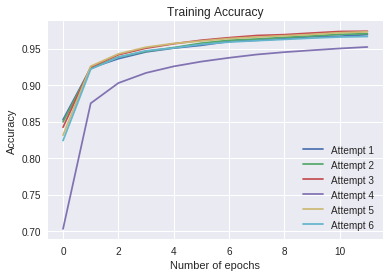

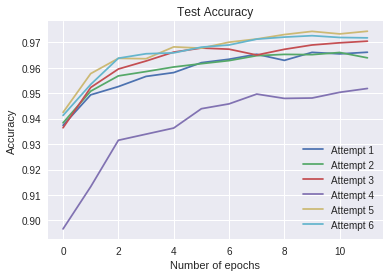

In [0]:
# Comparing accuracy (training and test)

# Training accuracy graph
plt.plot(history1.history['acc'])
plt.plot(history2.history['acc'])
plt.plot(history3.history['acc'])
plt.plot(history4.history['acc'])
plt.plot(history5.history['acc'])
plt.plot(history6.history['acc'])

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['Attempt '+str(i) for i in range(1,7)], loc='lower right')
plt.show()

# Test accuracy graph
plt.plot(history1.history['val_acc'])
plt.plot(history2.history['val_acc'])
plt.plot(history3.history['val_acc'])
plt.plot(history4.history['val_acc'])
plt.plot(history5.history['val_acc'])
plt.plot(history6.history['val_acc'])

plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['Attempt '+str(i) for i in range(1,7)], loc='lower right')
plt.show()


# FIGURE OUT HOW TO ZOOM IN ALSKDJLASKJDALKSDJ
# FIgure out how to put them on the same row (subplot?)

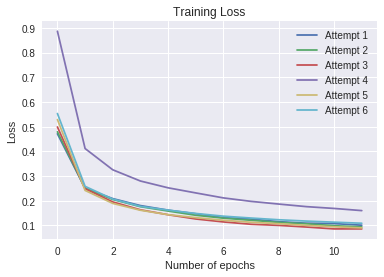

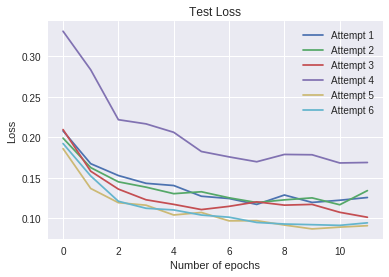

In [0]:
# Comparing loss (training and test)

# Training loss graph
plt.plot(history1.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history4.history['loss'])
plt.plot(history5.history['loss'])
plt.plot(history6.history['loss'])

plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['Attempt '+str(i) for i in range(1,7)], loc='upper right')
plt.show()

# Test loss graph
plt.plot(history1.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.plot(history4.history['val_loss'])
plt.plot(history5.history['val_loss'])
plt.plot(history6.history['val_loss'])

plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['Attempt '+str(i) for i in range(1,7)], loc='upper right')
plt.show()

### Final Model

In [0]:
# The final model we have chosen is Attempt 5

In [0]:
# Downloading more categories and more images for our final model to train on
# (50 categories)

max_categories = 345
num_categories = 50
max_drawings_per_category = 10000
x = (max_categories+1)//num_categories +1

bmp_data_all = list(bucket.list_blobs(prefix='full/numpy_bitmap'))
bmp_data = bmp_data_all[::x]

simp_data_all = list(bucket.list_blobs(prefix='full/simplified'))
simp_data = simp_data_all[::x]

x = list()
y = list()

for i, category in enumerate(bmp_data):
  file_name = os.path.basename(category.name).replace(' ', '_')
  print("{0}. downloading {1}...".format(i+1, file_name))
  category.download_to_filename(file_name)
  
  temp_df = simp_data[i].download_as_string().decode('utf-8')
  temp_df = pd.read_json(temp_df, lines=True)
  temp_list = np.load(file_name)
  
  for j, drawing in enumerate(temp_list):
    if temp_df['recognized'].iloc[j] == True:
      x.append(drawing.reshape(28,28))
      y.append(i)
    if len(y) >= (i+1)*max_drawings_per_category:
      break

1. downloading The_Eiffel_Tower.npy...
2. downloading angel.npy...
3. downloading axe.npy...
4. downloading basket.npy...
5. downloading bed.npy...
6. downloading birthday_cake.npy...
7. downloading bracelet.npy...
8. downloading bulldozer.npy...
9. downloading calendar.npy...
10. downloading canoe.npy...
11. downloading cello.npy...
12. downloading cloud.npy...
13. downloading cow.npy...
14. downloading diamond.npy...
15. downloading dragon.npy...
16. downloading elbow.npy...
17. downloading fan.npy...
18. downloading fish.npy...
19. downloading foot.npy...
20. downloading goatee.npy...
21. downloading hand.npy...
22. downloading hexagon.npy...
23. downloading hot_tub.npy...
24. downloading jail.npy...
25. downloading lantern.npy...
26. downloading lightning.npy...
27. downloading map.npy...
28. downloading monkey.npy...
29. downloading mouth.npy...
30. downloading octagon.npy...
31. downloading palm_tree.npy...
32. downloading peanut.npy...
33. downloading picture_frame.npy...
34. do

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


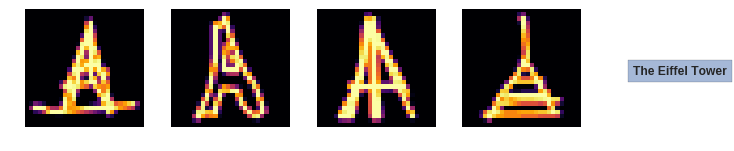

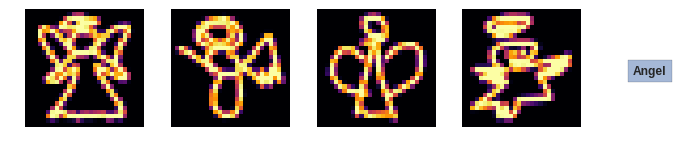

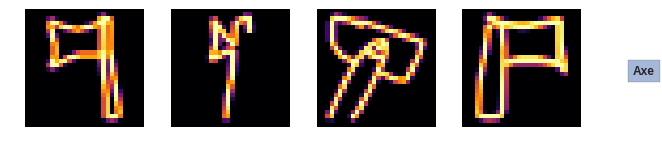

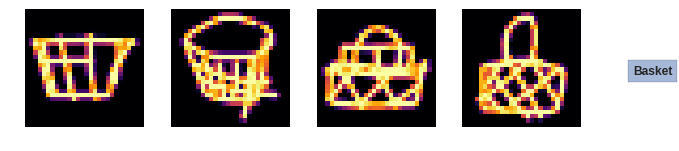

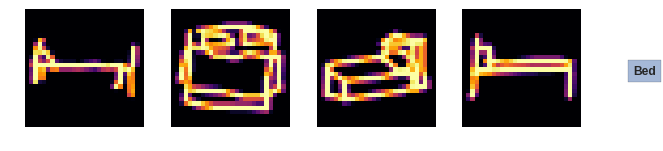

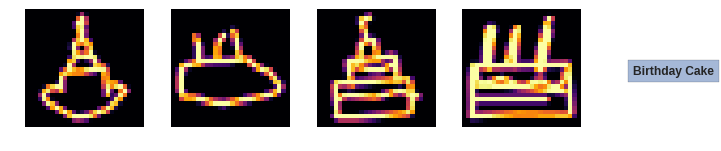

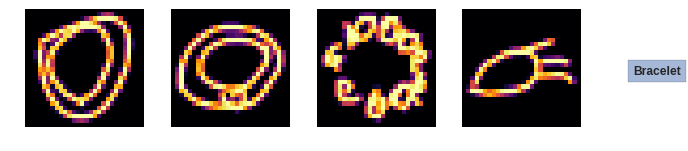

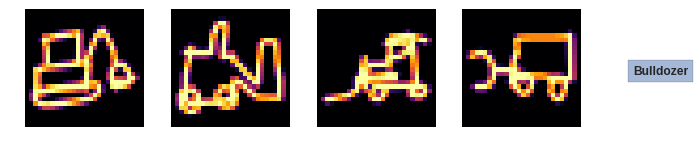

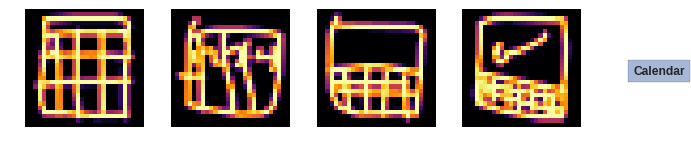

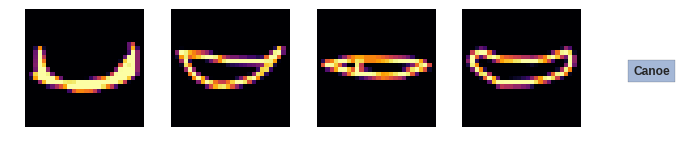

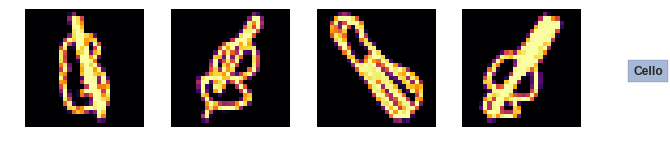

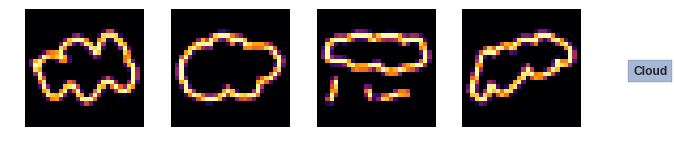

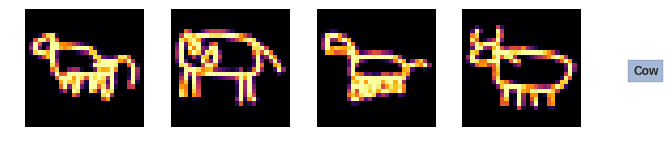

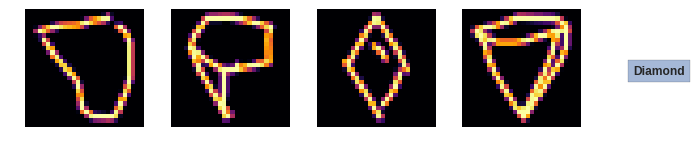

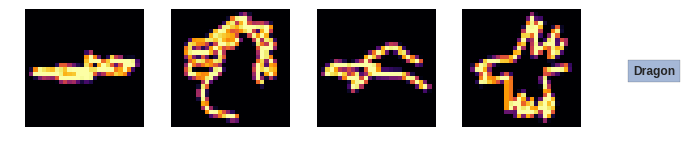

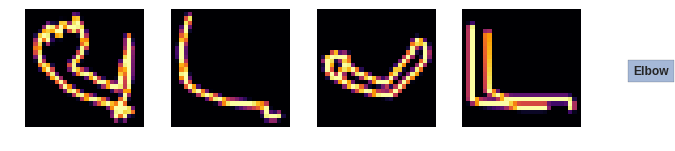

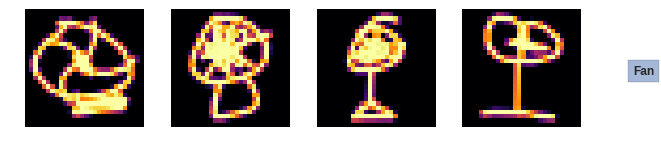

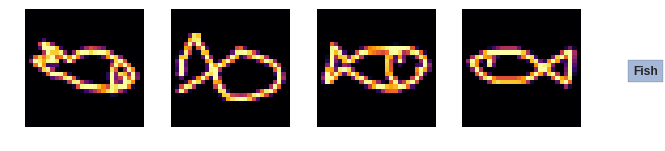

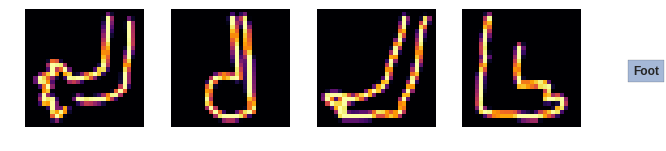

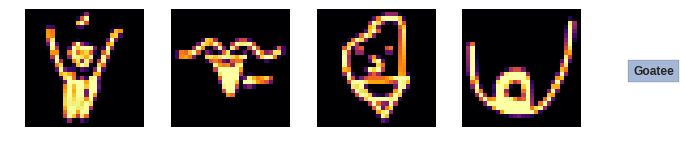

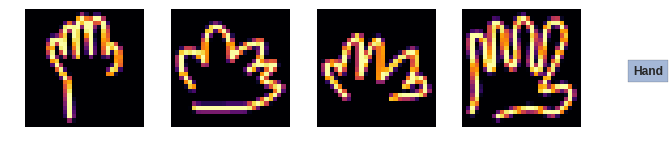

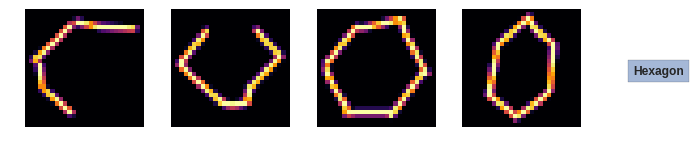

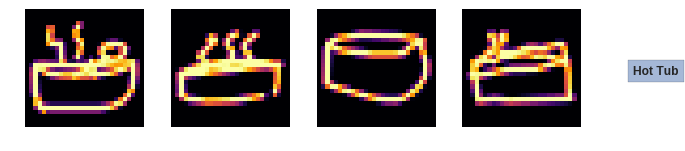

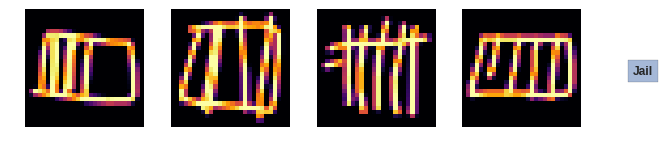

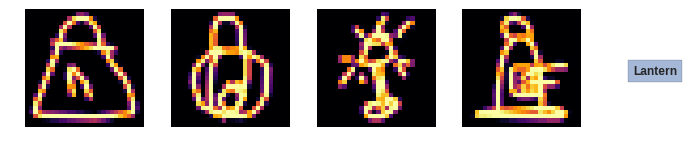

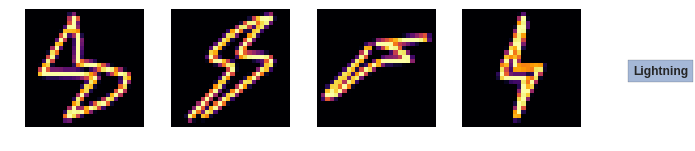

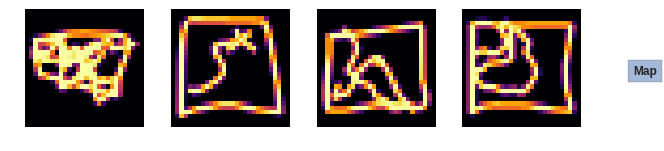

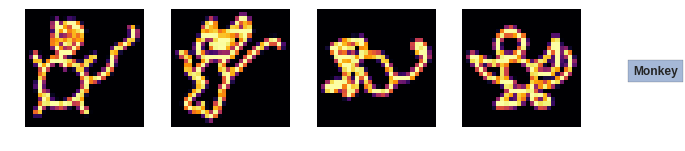

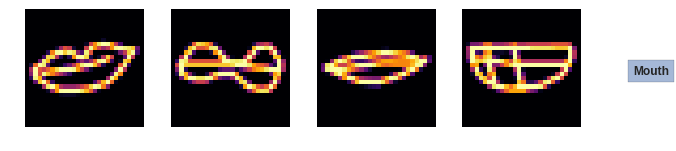

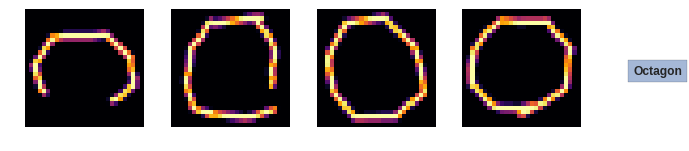

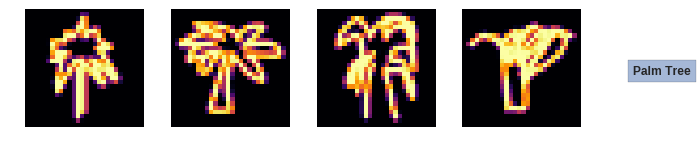

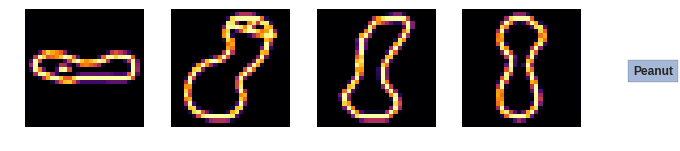

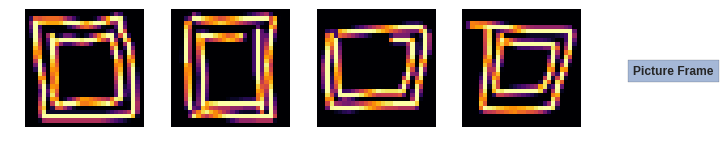

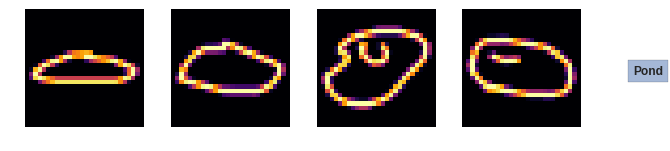

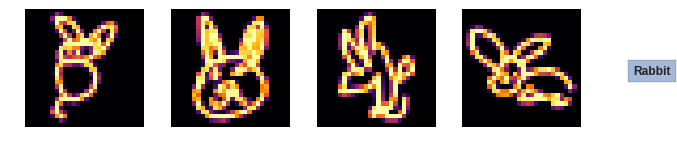

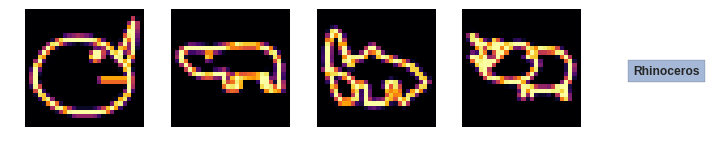

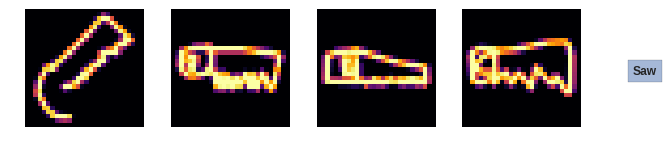

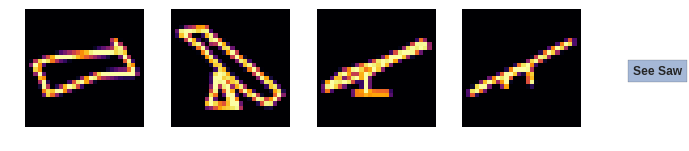

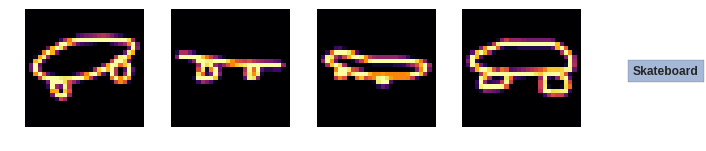

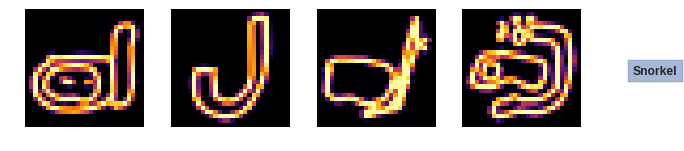

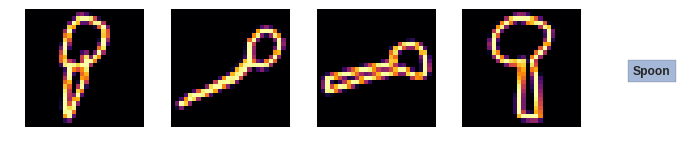

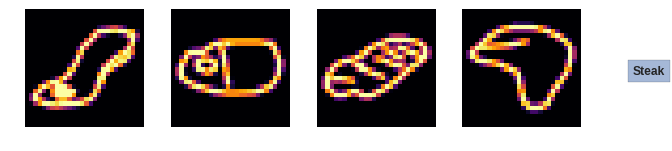

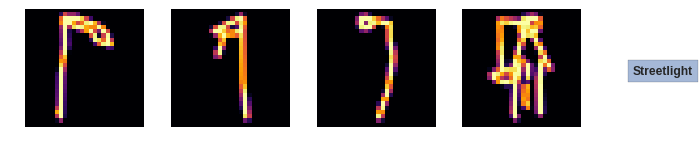

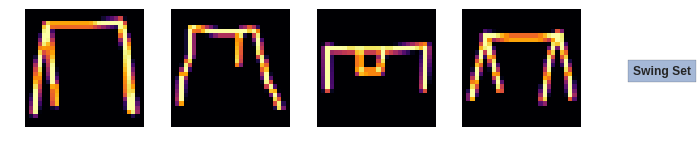

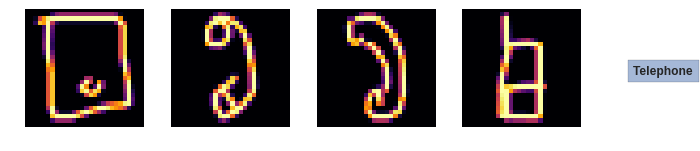

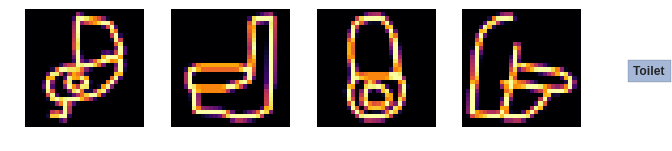

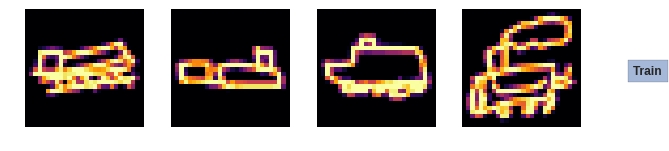

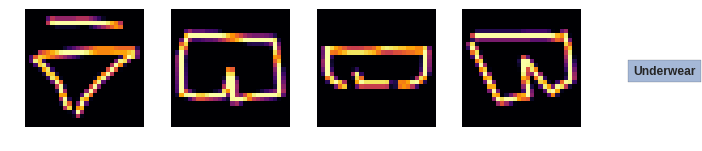

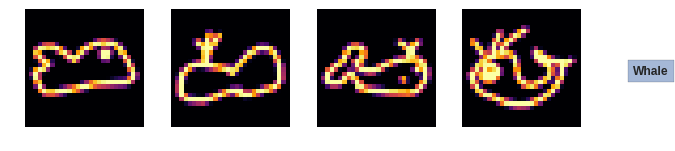

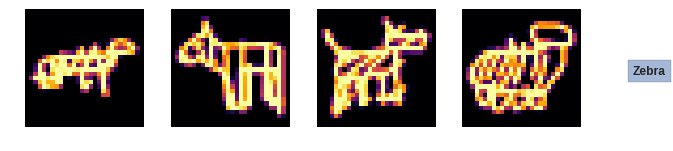

In [0]:
# visualizing the categories

display_num = 4  # pics per category to display
fig_length = 10  # the entire figure has size fig_side x fig_side
subplot_length = 4  # the size of each subplot in the figure has size subplot_length x subplot_length

for i, category in enumerate(bmp_data):
  fig = plt.figure(figsize=(fig_length, fig_length))
  for j in range(display_num):
    fig.add_subplot(subplot_length, subplot_length, j+1)
    plt.imshow(x[i*max_drawings_per_category+j])
    plt.axis('Off') # Don't show gridlines

  category_name = os.path.basename(category.name).title()
  category_name = os.path.splitext(category_name)[0]
  ax = fig.add_subplot(subplot_length, subplot_length, j+1)
  ax.text(40, 15, category_name, fontsize='large', fontweight='bold',
        bbox={'alpha': .5, 'pad': 5})
  
  plt.show()

In [0]:
# Final Model

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train_t = np.array(x_train)
x_test_t = np.array(x_test)
y_train_t = np.array(y_train)
y_test_t = np.array(y_test)

batch_size = 128
epochs = 12
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_categories)
y_test = keras.utils.to_categorical(y_test, num_categories)
  
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_categories, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)  

In [0]:
# Training time...

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=False,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 400000 samples, validate on 100000 samples
Epoch 1/12
400000/400000 [==============================] - 78s 195us/step - loss: 1.3275 - acc: 0.6278 - val_loss: 0.6386 - val_acc: 0.8144
Epoch 2/12
400000/400000 [==============================] - 72s 181us/step - loss: 0.8619 - acc: 0.7516 - val_loss: 0.5380 - val_acc: 0.8421
Epoch 3/12
400000/400000 [==============================] - 72s 181us/step - loss: 0.7615 - acc: 0.7802 - val_loss: 0.4861 - val_acc: 0.8554
Epoch 4/12
400000/400000 [==============================] - 72s 181us/step - loss: 0.7088 - acc: 0.7941 - val_loss: 0.4646 - val_acc: 0.8614
Epoch 5/12
400000/400000 [==============================] - 72s 181us/step - loss: 0.6766 - acc: 0.8039 - val_loss: 0.4407 - val_acc: 0.8690
Epoch 6/12
400000/400000 [==============================] - 72s 181us/step - loss: 0.6549 - acc: 0.8097 - val_loss: 0.4389 - val_acc: 0.8696
Epoch 7/12
400000/400000 [============================

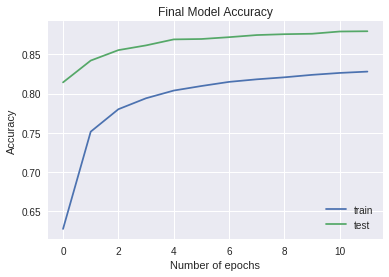

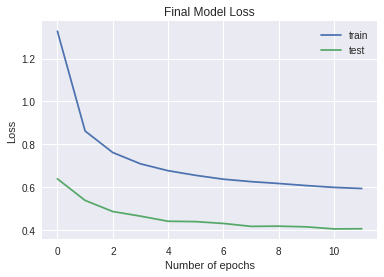

In [0]:
# Accuracy history for final model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# Loss history for final model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Final Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Visualizing Convolutional Filters

In [0]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

NameError: ignored

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# Note: we are only displaying a max of 63 filters because otherwise it looks ugly
# Note: we have 64 filters per layer, so the last one will not be displayed

def vis_img_in_filter(img = np.array(x[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_1'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 8, 8
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y))

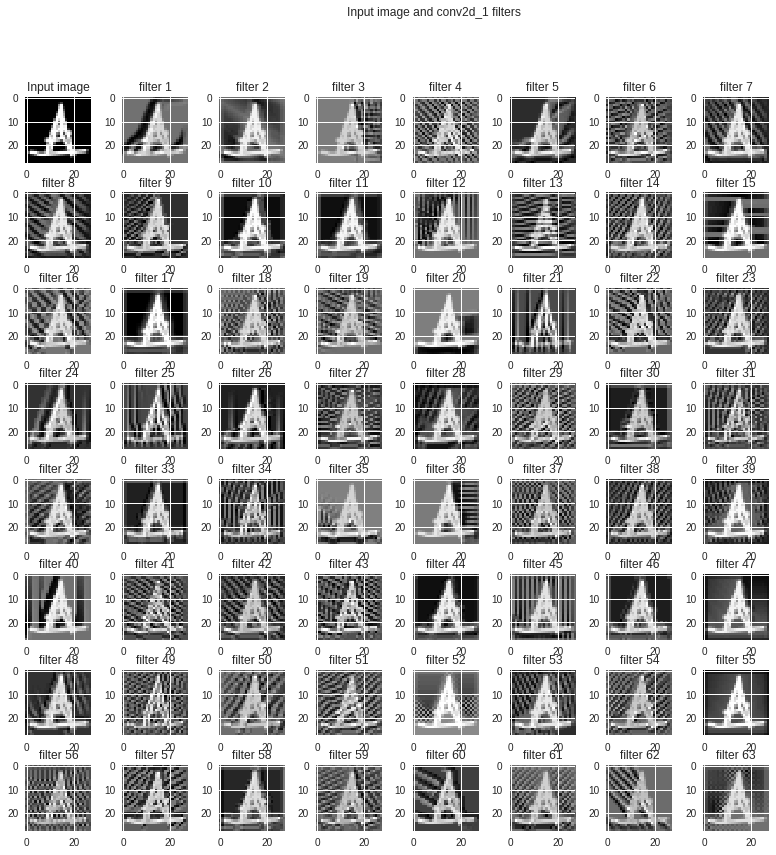

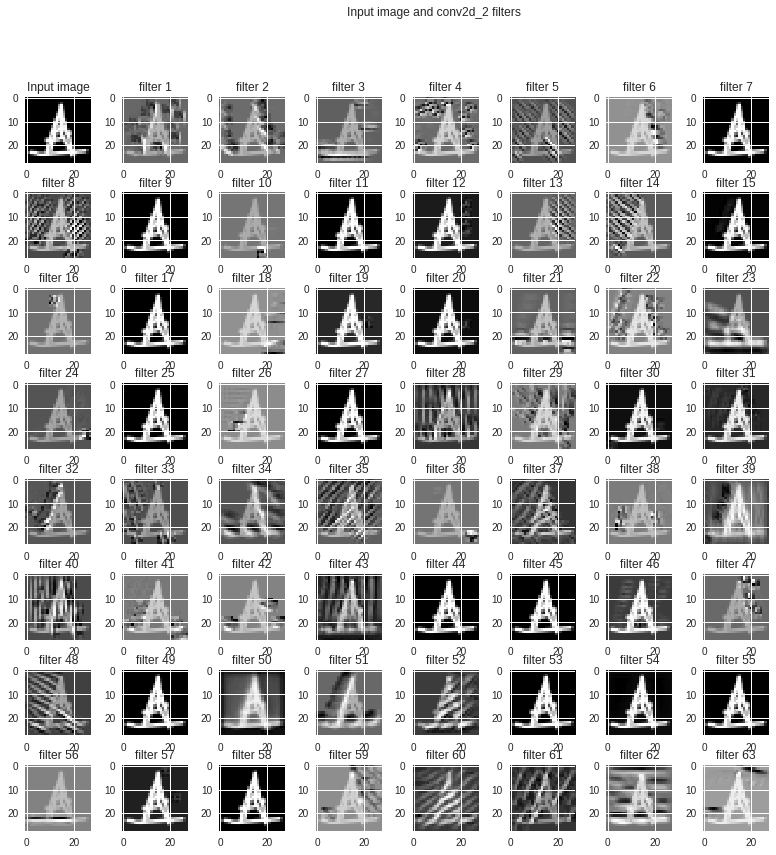

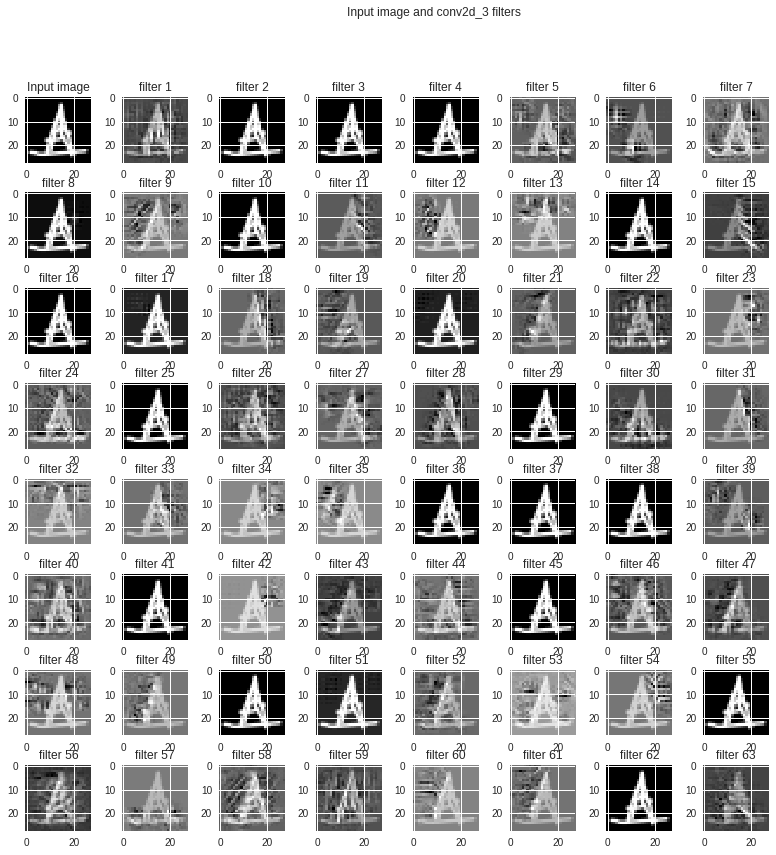

In [0]:
# display "all" convolutional filters (3 layers)
# default input image: first Eiffel Tower sketch

conv_layers = [0, 1, 3]

for i, layer in enumerate(model.layers):
  if i in conv_layers:
    vis_img_in_filter(layer_name = layer.name)

### Saliency Maps

In [0]:
from keras.layers import Input, Conv2DTranspose
from keras.models import Model
from keras.initializers import Ones, Zeros

# https://github.com/experiencor/deep-viz-keras/blob/master/saliency.py
class SaliencyMask(object):
    def __init__(self, model, output_index=0):
        pass

    def get_mask(self, input_image):
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image, dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

class GradientSaliency(SaliencyMask):

    def __init__(self, model, output_index = 0):
        # Define the function to compute the gradient
        input_tensors = [model.input]
        gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
        self.compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

    def get_mask(self, input_image):
        # Execute the function to compute the gradient
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value])[0][0]

        return gradients

# https://github.com/experiencor/deep-viz-keras/blob/master/visual_backprop.py
class VisualBackprop(SaliencyMask):
    def __init__(self, model, output_index = 0):
        inps = [model.input]           # input placeholder
        outs = [layer.output for layer in model.layers]    # all layer outputs
        self.forward_pass = K.function(inps, outs)         # evaluation function
        
        self.model = model

    def get_mask(self, input_image):
        x_value = np.expand_dims(input_image, axis=0)
        
        visual_bpr = None
        layer_outs = self.forward_pass([x_value, 0])

        for i in range(len(self.model.layers) - 1, -1, -1):
            if 'Conv2D' in str(type(self.model.layers[i])):
                layer = np.mean(layer_outs[i], axis = 3, keepdims = True)
                layer = layer - np.min(layer)
                layer = layer / (np.max(layer) - np.min(layer) + 1e-6)

                if visual_bpr is not None:
                    if visual_bpr.shape != layer.shape:
                        visual_bpr = self._deconv(visual_bpr)
                    visual_bpr = visual_bpr * layer
                else:
                    visual_bpr = layer

        return visual_bpr[0]
    
    def _deconv(self, feature_map):
        x = Input(shape = (None, None, 1))
        y = Conv2DTranspose(filters = 1, 
                            kernel_size = (3, 3), 
                            strides = (2, 2), 
                            padding = 'same', 
                            kernel_initializer = Ones(), 
                            bias_initializer = Zeros())(x)

        deconv_model = Model(inputs=[x], outputs=[y])

        inps = [deconv_model.input]   # input placeholder                                
        outs = [deconv_model.layers[-1].output]           # output placeholder
        deconv_func = K.function(inps, outs)              # evaluation function
        
        return deconv_func([feature_map, 0])[0]

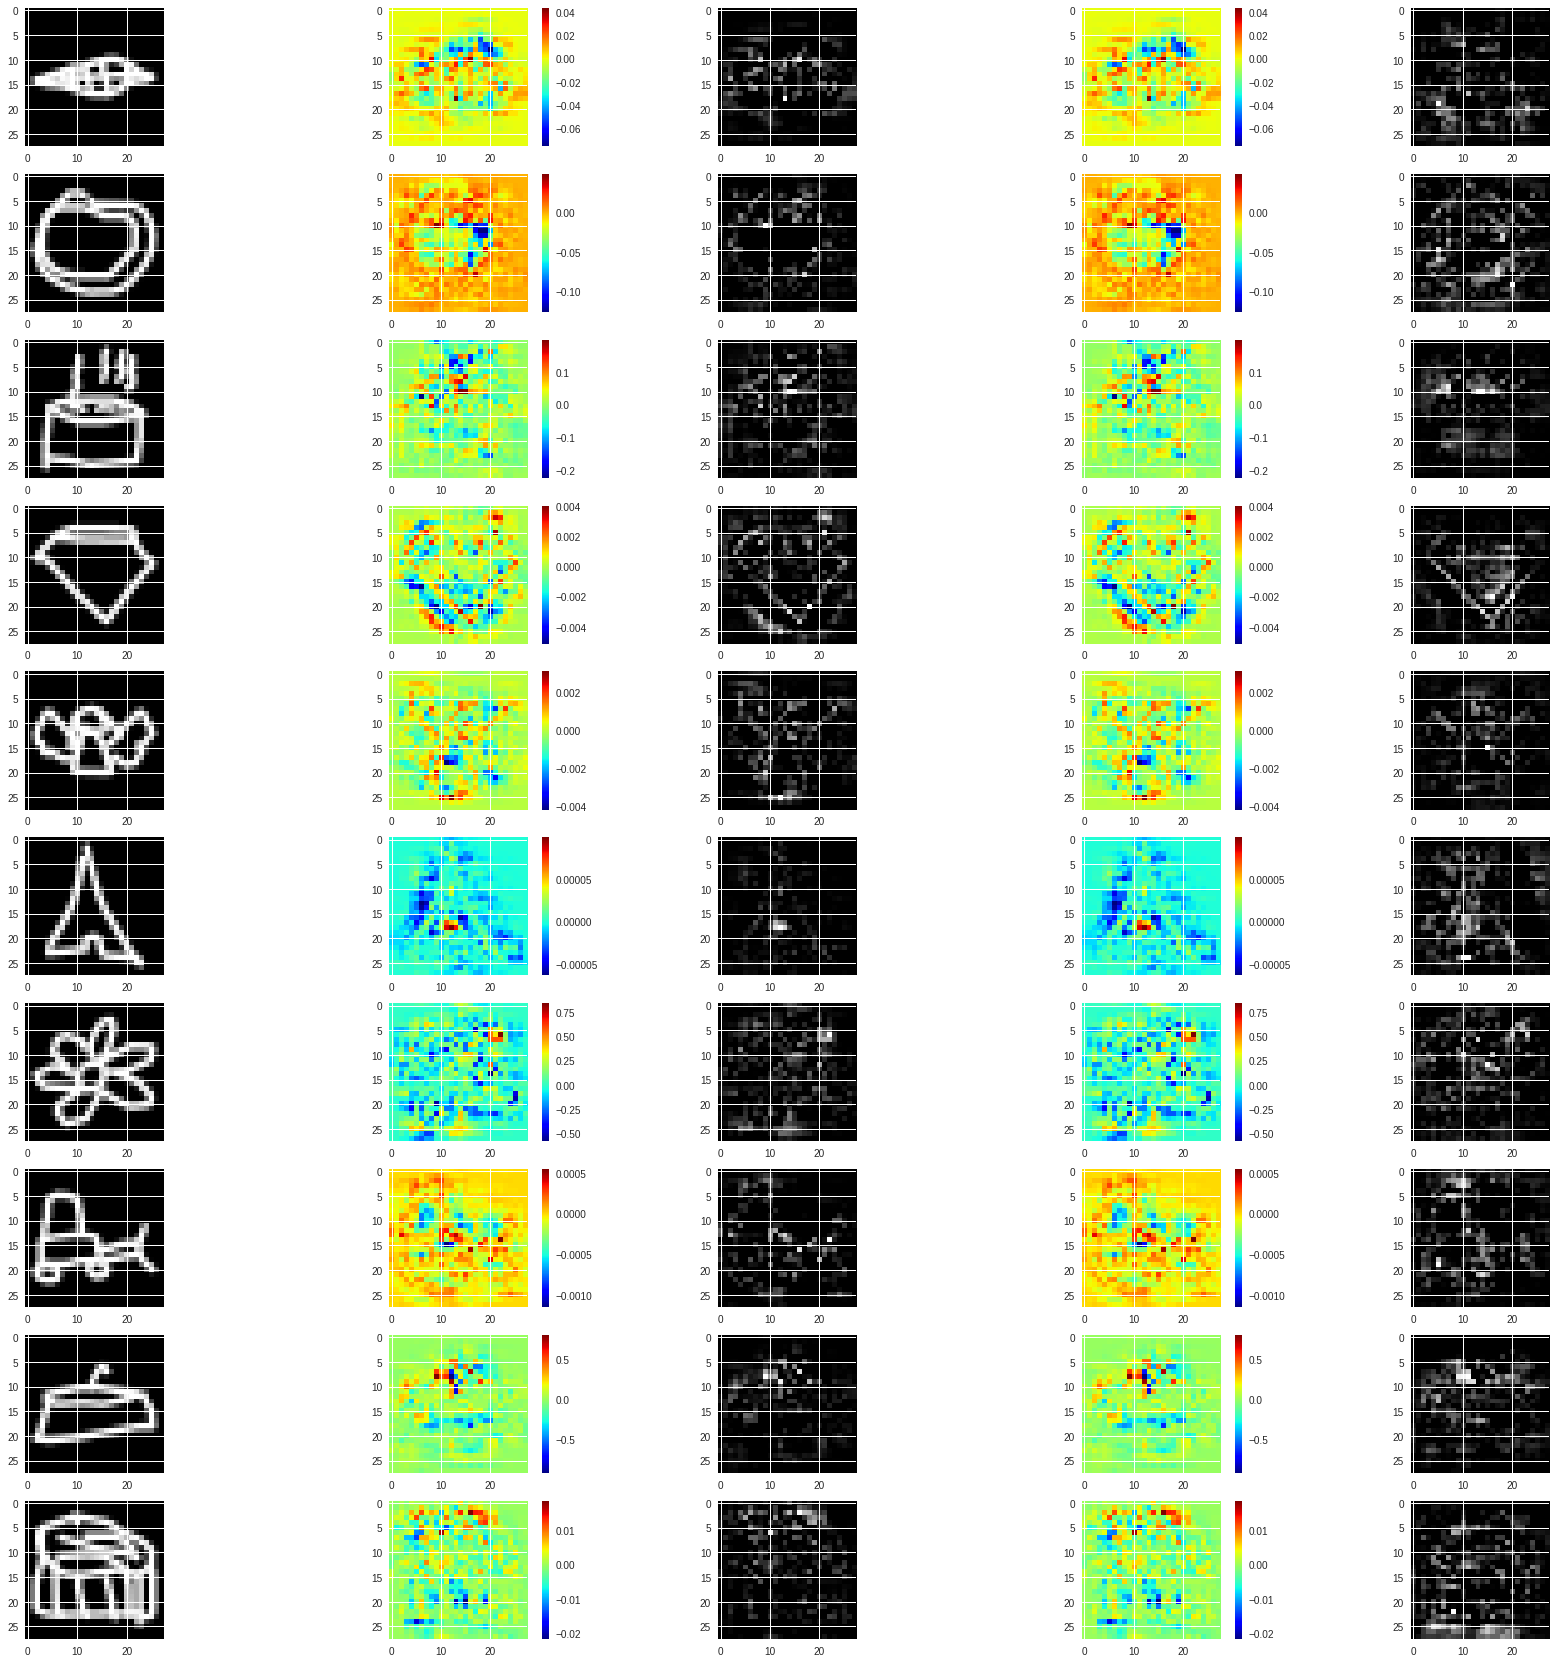

In [0]:
# visualize saliency maps on 10 random samples

from sklearn import preprocessing

Y_train = y_train
lb = preprocessing.LabelBinarizer()
lb.fit(Y_train)
Y_train = lb.transform(Y_train)
Y_train_label = lb.inverse_transform(Y_train)
n_classes = 10

find_1 = np.where(Y_train_label[0] == 1)
# print(Y_train_label[0][find_1])

#fig, ax = plt.subplots(n_classes, 5, figsize = (12, 16))
fig, ax = plt.subplots(n_classes, 5, figsize = (30, 30))

# for i in range(n_classes):
for i, data in enumerate(x_train[:10]):
    #img = np.array(x[i*8000])
    img = np.array(data)
    #print(img.shape)
    img = img.reshape(28,28)
    img = img.reshape(img.shape + (1,))
    #print(img.shape)
    
    #vanilla = GradientSaliency(model, Y_train_label[i])
    where = np.where(Y_train_label[i] == 1)
    #print(where[0][0])
    vanilla = GradientSaliency(model, where[0][0])

    mask = vanilla.get_mask(img)
    #print(mask)
    filter_mask = (mask > 0.0).reshape((28, 28))
    smooth_mask = vanilla.get_smoothed_mask(img)
    filter_smoothed_mask = (smooth_mask > 0.0).reshape((28, 28))

    ax[i, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    cax = ax[i, 1].imshow(mask.reshape((28, 28)), cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 1])
    ax[i, 2].imshow(mask.reshape((28, 28)) * filter_mask, cmap = 'gray')
    cax = ax[i, 3].imshow(mask.reshape((28, 28)), cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 3])
    ax[i, 4].imshow(smooth_mask.reshape((28, 28)) * filter_smoothed_mask, cmap = 'gray')

### Confusion Matrix

In [0]:
# putting category names in a list (for graph ticks)

categories = list()

for category in bmp_data:
  category_name = os.path.basename(category.name)
  category_name = os.path.splitext(category_name)[0]
  categories.append(category_name)

In [0]:
# predicting labels for the test set

lb = preprocessing.LabelBinarizer()
lb.fit(y_train_t)

# probabilities of belonging to each class (output after softmax layer)
Y_pred = model.predict(x_test) 

# this turns it into a label [0 28 40... ]
Y_pred_labels = lb.inverse_transform(Y_pred)

# turn OHE y_test also into label [20]
y_test_labels = lb.inverse_transform(y_test) 

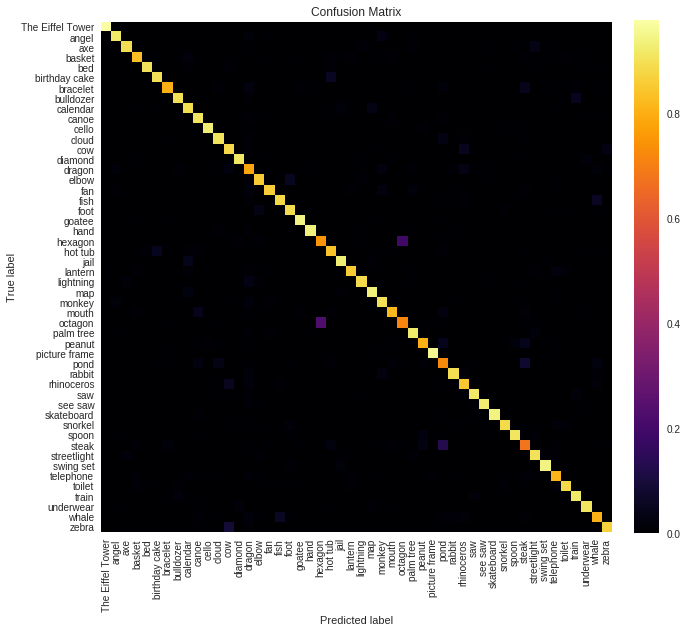

In [0]:
# displaying confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import itertools

# feed it to the confusion matrix
cm = confusion_matrix(y_test_labels, Y_pred_labels)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap = 'gray')
plt.inferno()
plt.title('Confusion Matrix')
plt.colorbar(fraction=0.046, pad=0.04)  # stupid colorbar needs to match plot height

tick_marks = np.arange(num_categories)
plt.xticks(tick_marks, categories, rotation=90)
plt.yticks(tick_marks, categories)

fmt = '.2f'
thresh = cm.max() / 2.

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.grid(False)

In [0]:
# the following code was written after many notebook crashes due to exceeding RAM limits

def save_data():
  import pickle
  # save all of our variables in case of a crash
  with open('x.txt', 'wb') as f:
    pickle.dump(x, f)

  with open('y.txt', 'wb') as f:
    pickle.dump(y, f)

def load_data():
  import pickle
  # save all of our variables in case of a crash
  with open('x.txt', 'rb') as f:
    x = pickle.load(f)

  with open('y.txt', 'rb') as f:
    y = pickle.load(f)
  return x,y

In [0]:
save_data()

In [0]:
load_data()